In [1]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Define directory paths
base_dir = 'processed_waste_data'  # Update this if your data is in a different path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

# Define data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Set up the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data to maintain consistency during evaluation
)


Found 1512 images belonging to 7 classes.
Found 507 images belonging to 7 classes.
Found 508 images belonging to 7 classes.


In [3]:
# Load ResNet50 with pre-trained ImageNet weights, without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers in ResNet50 to retain learned features
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [4]:
# Add custom layers on top of the base ResNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces dimensions, preparing for dense layers
x = Dense(128, activation='relu')(x)  # Add fully connected layer
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
# Compile the model with a low learning rate suitable for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Early stopping and learning rate reduction to avoid overfitting and improve training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [7]:
# Train the model
epochs = 30  # Start with 30 epochs and allow early stopping to decide the best epoch count

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\Ansh Patel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1667 - loss: 1.9826

C:\Users\Ansh Patel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.1671 - loss: 1.9814 - val_accuracy: 0.2396 - val_loss: 1.7419 - learning_rate: 1.0000e-04
Epoch 2/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 2:56 4s/step - accuracy: 0.3125 - loss: 1.7720

C:\Users\Ansh Patel\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.3125 - loss: 1.7720 - val_accuracy: 0.1481 - val_loss: 1.7801 - learning_rate: 1.0000e-04
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.2168 - loss: 1.8399 - val_accuracy: 0.2396 - val_loss: 1.7299 - learning_rate: 1.0000e-04
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2188 - loss: 1.9234 - val_accuracy: 0.1481 - val_loss: 1.7257 - learning_rate: 1.0000e-04
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.1956 - loss: 1.7998 - val_accuracy: 0.2333 - val_loss: 1.7169 - learning_rate: 1.0000e-04
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3125 - loss: 1.6776 - val_accuracy: 0.2593 - val_loss: 1.7970 - learning_rate: 1.0000e-04
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.2203 - loss: 1.7733 - val_accuracy: 0.2333 - val_loss: 1.7183 - learning_rate: 1.0000e-04
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.1562 - loss: 1.

In [8]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.1227 - loss: 1.7272
Test Accuracy: 23.43%


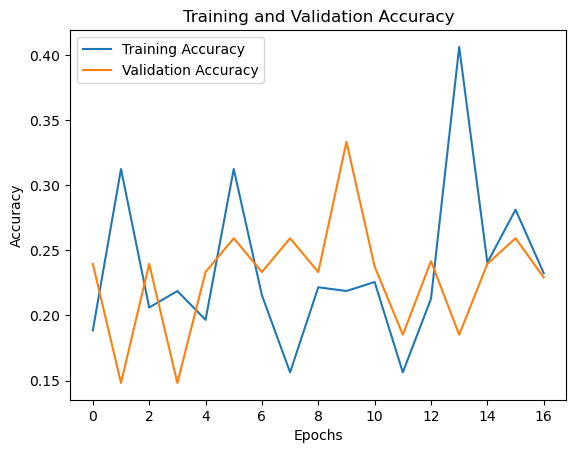

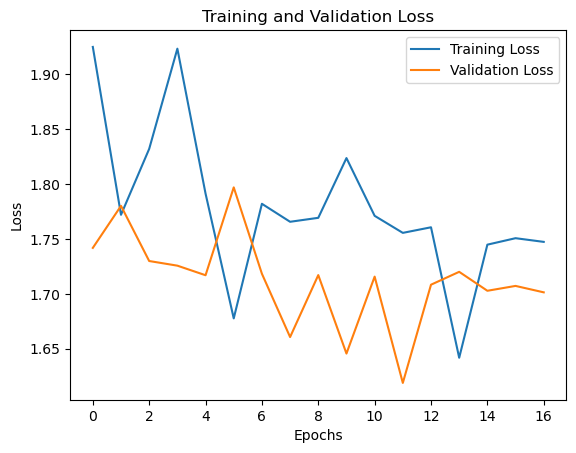

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()